# Wind Farm Test
In this file, one can test certain wind farm layouts and configurations. Some basic functions are demonstrated. With the resulting turbine power outputs and flowfields, one can make their own comparisons between farms.

### Import libraries
Here, the libraries used in this file are imported.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
from scipy import optimize

# Import custom libraries
import functions as func
import visualization as viz
import optimization as opt
from optimization import Optimization
from cases import (
    Case,
    CaseManager,
)

# Import models
from models.LES import LES
from models.CCM import CCM
from models.TestModel import TestModel

# Get some of the most beautiful color schemes you've ever seen
colors, colorgrad = viz.get_color_schemes()

### Choose model

In [2]:
model = CCM()
ref_model = LES()

### Create case manager

In [3]:
# Add new case
test_casemanager = CaseManager(
    name='Test Case Manager',
    ref_model=ref_model,
    ref_data_location='../LES/',
    ref_standard_case='1TURB_wd270_ws10_1x_y0_t5',
)

# Set masks to select cases from csv-file
masks = {
    'test': 1,
    'optimization': 1,
}

# Load csv files
test_casemanager.load_csv_cases(
    location='../TouchWind_Optimization_Framework/',
    file_name='test_cases.csv',
    masks=masks,
)

# Print all case names
for name in test_casemanager.case_names:
    print(name)

1x1TURB_wd270_ws10_1x_y0_t5
2x2TURB_wd270_ws10_4x_y0_t5
3TURB_wd270_ws10_3x_y0_t-30
3x3_optimization_test
6x6_optimization_test


Total power:    39.50000000000001 MW)


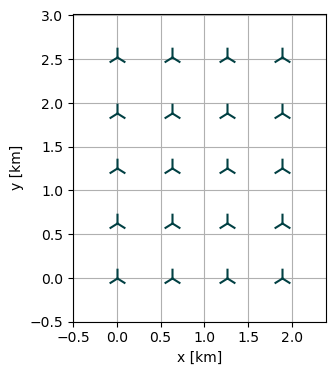

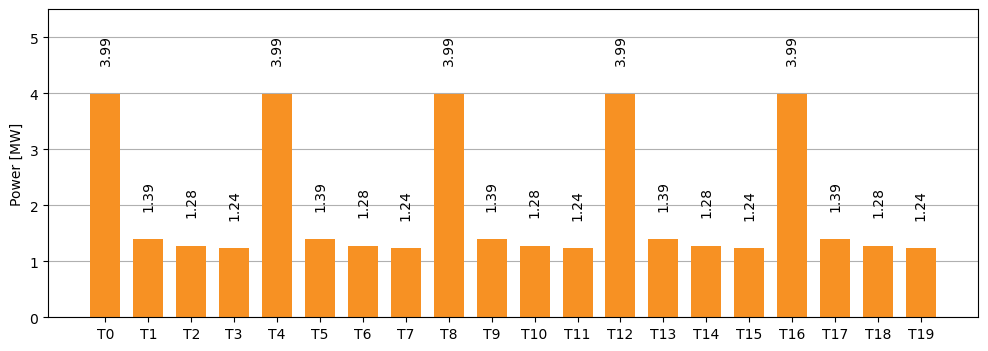

In [4]:
# Create instance of case
custom_case_1 = Case(
    name='custom_case_1',
)

# Set conditions
custom_case_1.set_conditions(
    directions=np.array([270]),
    speeds=np.array([10]),
    TI=np.array([0.06]),
    ABL_params=None,
)

# Set wind farm layout
custom_case_1.set_layout(
    shape='rectangular',
    n_x=4,
    n_y=5,
    spacing_x=5,
    spacing_y=5,
    D_rotor=126,
    x_i=None, 
    y_i=None,
)

# Set turbine properties
custom_case_1.set_turbines(
    yaw_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 0,
    tilt_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 0,
    thrustcoef_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 1,
)

# Run case and plot layout and powers
turbine_powers = model.run(
    custom_case_1,
)

print(f'Total power:    {np.sum(np.round(turbine_powers/1e6, 2))} MW)')
viz.plot_farm_layout(
        custom_case_1.layout['x_i'],
        custom_case_1.layout['y_i']
    )
viz.plot_turbine_powers(turbine_powers[0, 0])

### Run cases

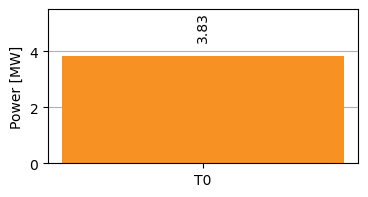

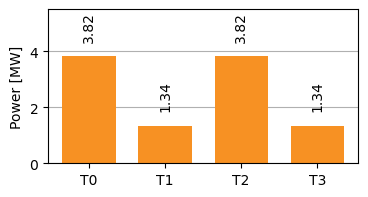

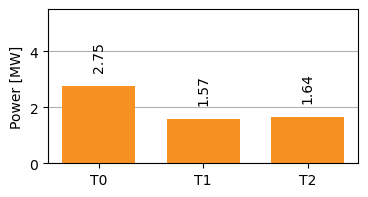

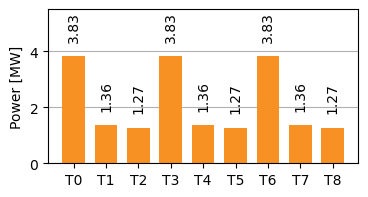

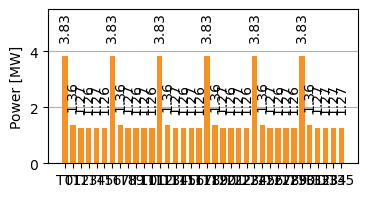

In [5]:
cases = test_casemanager.get_cases()

for case in cases:
    turbine_powers = model.run(
        case
    )
    viz.plot_turbine_powers(turbine_powers[0, 0], figsize=(4, 2))

### Plot flowfields

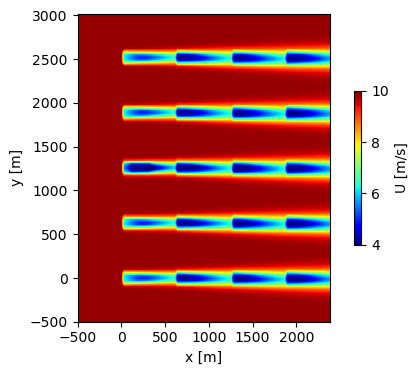

In [7]:
viz.plot_velocity_field(
    model,
    custom_case_1,
    plane='Z',
)

### Optimization

In [38]:
# Optimization algorithm

# Select case for optimization
case_name = '3x3_optimization_test'
optimization_case = copy.deepcopy(test_casemanager.cases[case_name])

# Select parameters to optimize
optimization_parameters = [
    'yaw',
    'tilt',
    # 'thrustcoef',
]

# Set location and file name of resulting data
result_location = '../Optimization Results/'
result_filename = f'{case_name}.csv'

# Set optimization algorithm settings
method = 'SLSQP'
penalty = True
options = {
    'disp': True,
    'maxiter': 100,
    'eps': None,
}
tolerance = 1e-6

# Set wind directions and uncertainty parameters
wind_directions = np.linspace(225, 312, 30)
# wind_directions = np.linspace(270, 300, 2)
wind_speeds = np.linspace(10, 10, 1)
exclude_range = 120
n_discretized_wds = 7
sigma_wd = 5.25

# Set wind turbine properties
bounds = {
    'yaw': (-40, 40),
    'tilt': (-50, -5),
    'thrustcoef': (0.01, 0.99),
}
guesses = {
    'yaw': 0,
    'tilt': -5,
    'thrustcoef': 1,    
}

downwind_values = guesses
# NOTE: Downwind value of thrust coefficient must be 1
downwind_values['thrustcoef'] = 1

# Get number of turbines
n_turbines = optimization_case.layout['n_turbines']

# Initialize dataframe for wind farm data
df_optimization = opt.get_optimization_dataframe(
    result_location,
    result_filename,
    optimization_parameters,
    optimization_case.layout,
)

# Get downwind mask for all wind directions
downwind_masks = func.get_downwind_masks(
    wind_directions,
    optimization_case.layout,
    exclude_range,
)

# Get parameter names, bounds and guesses dictionaries corresponding with result lists
result_bounds_guess_dicts = opt.get_result_bounds_guess_dicts(
    optimization_parameters,
    downwind_masks,
    bounds,
    guesses,
)

# TODO: Get conventional total powers
turbine_powers_conv = opt.get_turbine_powers_conv(
    model,
    optimization_case,
    wind_directions,
    downwind_values,
)
total_powers_conv = np.sum(turbine_powers_conv, axis=2)[:, 0]

# Start optimization framework
start_time = time.time()

for idw, wd in enumerate(wind_directions):
    # Get conventional total power
    total_power_conv = total_powers_conv[idw]

    # Get lists of parameter names, bounds and guesses
    dictionary = result_bounds_guess_dicts[idw]
    parameter_names = list(dictionary.keys())
    parameter_bounds = [i[0] for i in list(dictionary.values())]
    parameter_guesses = [i[1] for i in list(dictionary.values())]

    # Initialize optimization class for wind direction
    optimization = Optimization(
        model=model,
        case=optimization_case,
        wd=wd,
        vars=optimization_parameters,
        mask=downwind_masks[idw],
        method=method,
        penalty=penalty,
        total_power_conv=total_power_conv,
        downwind_values=downwind_values,
        n_particles=1,
        n_discretized_wds=n_discretized_wds,
        sigma_wd=sigma_wd,
    )

    # Run optimization algorithm
    start_time_wd = time.time()

    result = optimize.minimize(
        fun=optimization.cost_function,
        x0=parameter_guesses,
        tol=tolerance,
        bounds=parameter_bounds,
        options=options,
    )

    end_time_wd = time.time()

    # Get optimized wind turbine parameter set
    parameters_optimized = result.x

    # Get complete wind turbine parameter set
    all_parameters = opt.get_all_parameters(
        n_turbines,
        parameter_names,
        parameters_optimized,
        optimization_parameters,
        downwind_values,
    )

    # Get total power and turbine powers
    total_power = optimization.total_power
    turbine_powers = optimization.turbine_powers

    # Save wind farm data in new row dictionary
    dict_new_row =  all_parameters.copy()
    dict_new_row['wind_direction'] = wd
    dict_new_row['total_power'] = total_power
    dict_new_row['total_power_conv'] = total_power_conv
    dict_new_row['time'] = end_time_wd - start_time_wd
    dict_new_row['success'] = result.success
    dict_new_row['message'] = result.message
    dict_new_row['n_iterations'] = result.nit
    dict_new_row['function_values'] = optimization.function_values
    dict_new_row['result'] = result
    
    for turb in range(n_turbines):
        dict_new_row[f'power_{turb}'] = turbine_powers[turb]
    
    # Add new row to dataframe
    df_new_row = pd.DataFrame([dict_new_row])
    df_optimization = pd.concat([df_optimization, df_new_row], ignore_index=True)
    
    # Save optimization data
    df_optimization.to_csv(result_location + result_filename, index=False)

    # Print progress and estimated time
    opt.print_progress(
        start_time,
        idw,
        wind_directions,
    )

# TODO save settings in txt file

Progress: 100.0 %
    Mean time per optimization run: 0.0 minutes
    Estimation: 0 minutes remaining
    Currently at wind direction 312.0 (30 of 30)


### Optimization visualization

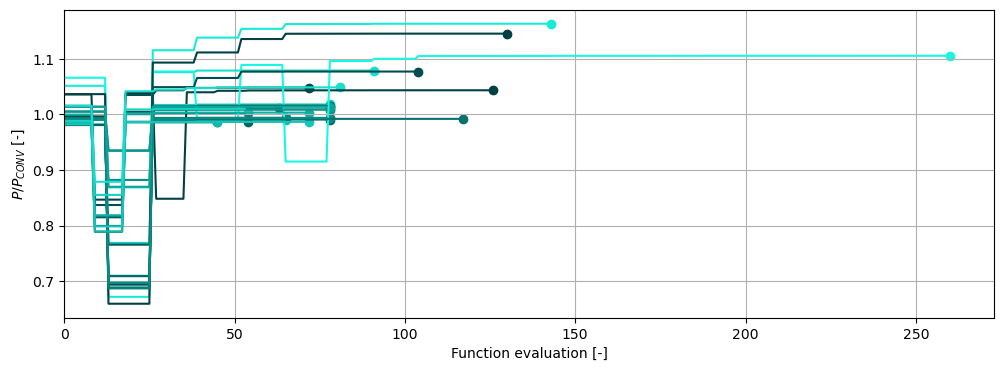

In [41]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_optimization)):
    values = df_optimization['function_values'].iloc[i] / df_optimization['total_power_conv'][i]
    ax.plot(values, color=colorgrad[i%len(colorgrad)])
    ax.scatter(len(values), values[-1], color=colorgrad[i%len(colorgrad)])
ax.set_xlabel('Function evaluation [-]')
ax.set_ylabel('$P/P_{CONV}$ [-]')
ax.grid()
ax.set_xlim(0,)
plt.show()

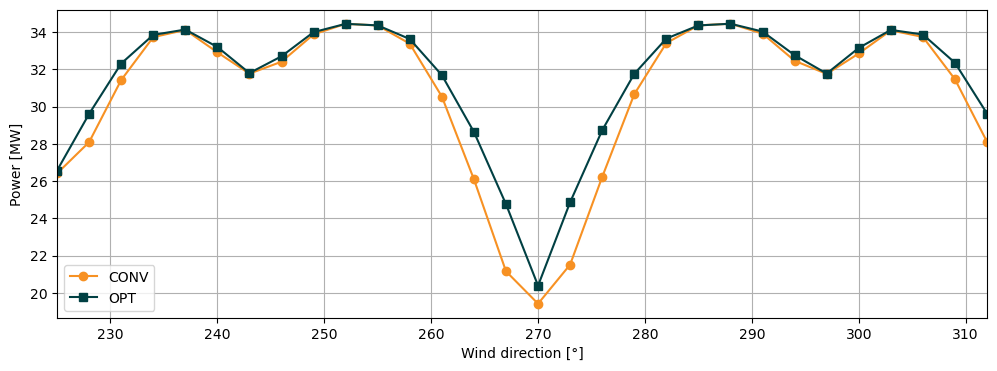

In [42]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['total_power_conv']/1e6, color=colors[0], label='CONV', marker='o')
ax.plot(df_optimization['wind_direction'], df_optimization['total_power']/1e6, color=colors[1], label='OPT', marker='s')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Power [MW]')
ax.grid()
ax.legend()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

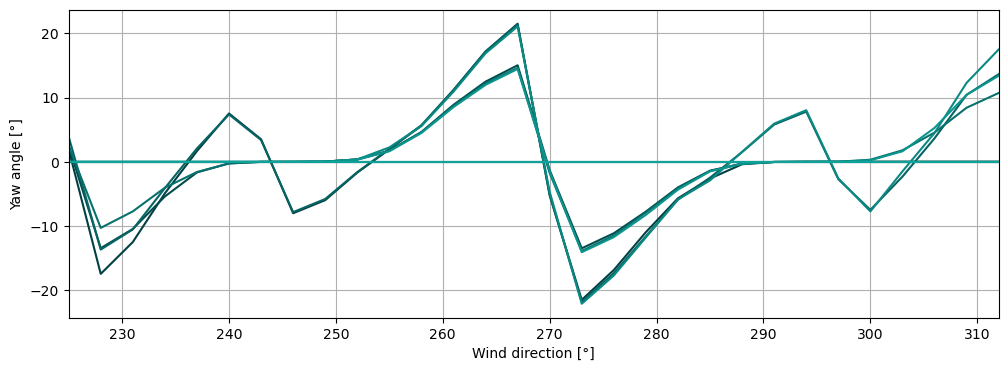

In [45]:
value = 'yaw'

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for turb in range(n_turbines):
    if value == 'power':
        ax.plot(df_optimization['wind_direction'], df_optimization[f'{value}_{turb}']/1e6, color=colorgrad[turb%len(colorgrad)])
    else:
        ax.plot(df_optimization['wind_direction'], df_optimization[f'{value}_{turb}'], color=colorgrad[turb%len(colorgrad)])
ax.set_xlabel('Wind direction [°]')
if value == 'power':
    ax.set_ylabel('Power [MW]')
elif value == 'yaw':
    ax.set_ylabel('Yaw angle [°]')
elif value == 'tilt':
    ax.set_ylabel('Tilt angle [°]')
elif value == 'thrustcoef':
    ax.set_ylabel('Thrust coefficient [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

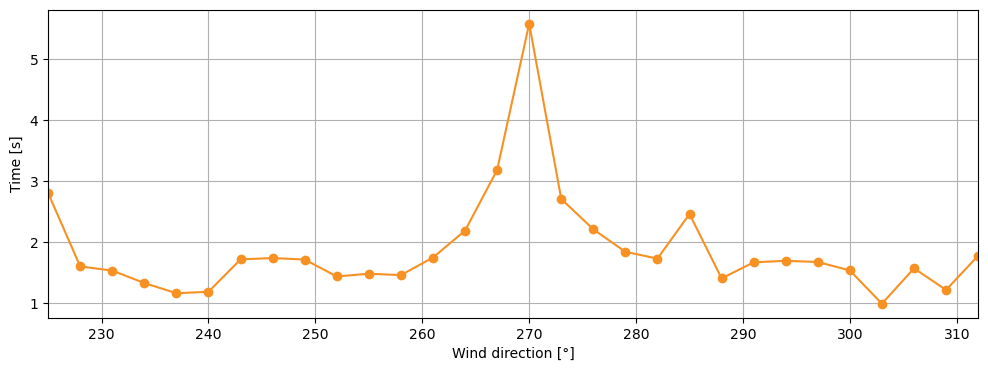

In [46]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['time'], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Time [s]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

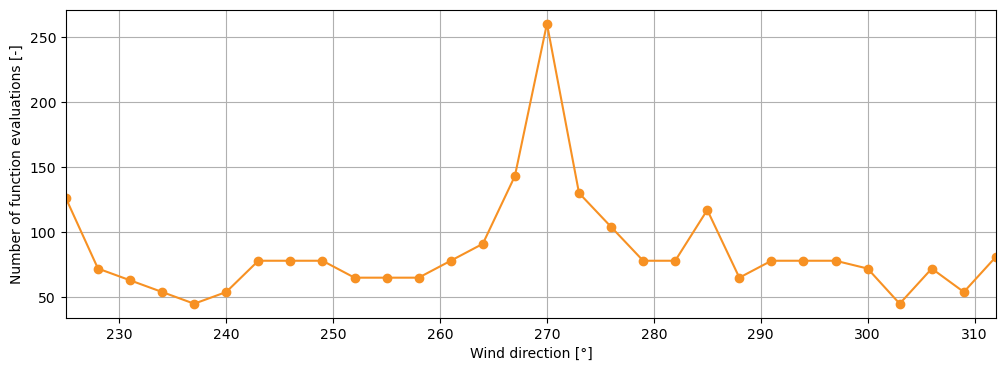

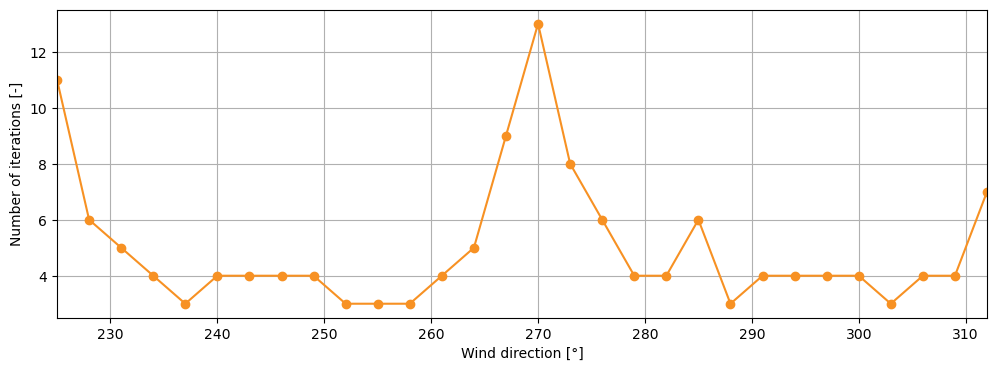

In [47]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], [len(i) for i in df_optimization['function_values']], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Number of function evaluations [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['n_iterations'], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Number of iterations [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()